In [122]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from finetune import finetune_resnet
import random

from galaxy_datasets import gz2
from galaxy_datasets.pytorch.galaxy_dataset import GalaxyDataset  # generic Dataset for galaxies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [124]:
# Directories
data_dir = './data/gz2/'#'~/../../checkpoints/aa/galaxy-zoo-data/gz2'
os.makedirs(data_dir, exist_ok=True)
save_dir = '~/../../checkpoints/aa/galaxy-zoo-data/gz2-models'
os.makedirs(save_dir, exist_ok=True)

In [125]:
train_catalog, train_label_cols = gz2(
    root=data_dir,
    train=True,
    download=False
)
val_catalog, val_label_cols = train_catalog.sample(frac=0.1), train_label_cols
train_catalog.drop(val_catalog.index)
test_catalog, test_label_cols = gz2(
    root=data_dir,
    train=False,
    download=False
)

In [126]:
train_dataset = GalaxyDataset(
    catalog=test_catalog.sample(len(test_catalog)),  # from gz2(...) above
    label_cols=['has-spiral-arms-gz2_yes', 'has-spiral-arms-gz2_no'],
    target_transform=tv.transforms.Lambda(lambda y: int(y[0] > y[1]))
)
val_dataset = GalaxyDataset(
    catalog=val_catalog.sample(len(val_catalog)),  # from gz2(...) above
    label_cols=['has-spiral-arms-gz2_yes', 'has-spiral-arms-gz2_no'],
    target_transform=tv.transforms.Lambda(lambda y: int(y[0] > y[1]))
)
test_dataset = GalaxyDataset(
    catalog=train_catalog.sample(len(train_catalog)),  # from gz2(...) above
    label_cols=['has-spiral-arms-gz2_yes', 'has-spiral-arms-gz2_no'],
    target_transform=tv.transforms.Lambda(lambda y: int(y[0] > y[1]))
)

datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test":  test_dataset
}

1


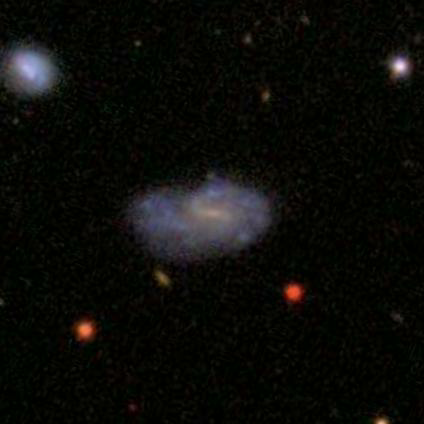

In [128]:
sample_idx = 1
print(test_dataset[sample_idx][1])
test_dataset[sample_idx][0]

In [ ]:
num_classes = 2
batch_size = 64
num_epochs = 1
feature_extract = True
num_workers = 4
finetune_resnet(
        datasets,
        save_dir,
        num_classes,
        batch_size,
        num_epochs,
        feature_extract,
        num_workers
    )

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/0
----------


  8%|███████▌                                                                                           | 50/655 [02:16<28:14,  2.80s/it]